In [138]:
# A Quantum Circuit to Construct All Maximal Cliques Using Grover’s Search Algorithm

## Chu Ryang Wie

### DOI: https://arxiv.org/abs/1711.06146v2

In [1]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from qiskit import *
# IBMQ.load_account()
from qiskit.visualization import *

In [2]:
n = 3 # size of network
psi  = QuantumRegister(n, name='psi') # cliques states
data = QuantumRegister(n**2, name='data') # data A+I states
ancl = QuantumRegister(n**2, name='ancl') # ancilla states
cpsi = ClassicalRegister(n, name='cpsi') # classical register for measurement
cdata = ClassicalRegister(n**2, name='cdata') # classical register for measurement
cancl = ClassicalRegister(n**2, name='cancl') # classical register for measurement

#extra_ancl = QuantumRegister(n**2, name='extra_ancl')
qc   = QuantumCircuit(psi, data, ancl, cpsi, cdata, cancl, name='maximal cliques')

In [3]:
import numpy as np
A = np.array([ # creating adjacency matrix
    [0,1,0],
    [1,0,1],
    [0,1,0]
], dtype=np.int)

AI = A+ np.eye(n, dtype=np.int)


In [4]:
# setting network structure on data qubits
for ij, cij in enumerate(AI.flatten()):
    if cij:
        qc.x(data[ij])

In [5]:
# putting cliques on uniform superposition
for j in range(n):
    qc.h(psi[j])

In [6]:
def V():
    for j in range(n):
        for i in range(n):
            # applying 'intersect operator' as defined in paper
            qc.barrier()
            # standard toffoli
            qc.ccx(psi[j], data[j*n+i], ancl[j*n+i])
            
            # toffoli variant - 1st ctrl qbit works when 0
            qc.x(psi[j])
            qc.ccx(psi[j], data[j*n+i], ancl[j*n+i])
            
            # toffoli variant - 1st & 2nd ctrl qbit work when 0
            qc.x(data[j*n+i])
            qc.ccx(psi[j], data[j*n+i], ancl[j*n+i])
            
            # undoing NOT operations
            qc.x(psi[j])
            qc.x(data[j*n+i])

def W():
    for j in range(n):
        # trying to use multi-controlled toffoli gate available in qiskit (not sure if it works)
        #qc.mct(ancl[j::n], psi[j], extra_ancl)
        #QuantumCircuit.mct(q_controls, q_target, q_ancilla, mode='basic')
        qc.barrier()
        qc.mct(ancl[j::n], psi[j], None, mode='noancilla')

def flip_ket_0():
    for j in range(n):
        qc.x(psi[j])
    qc.h(psi[n-1])
    qc.barrier()
    qc.mct(psi[:-1], psi[-1], None, mode='noancilla')
    qc.barrier()
    qc.h(psi[n-1])
    for j in range(n):
        qc.x(psi[j])

def O():
    qc.barrier()
    V()
    qc.barrier()
    W()
    qc.barrier()
    flip_ket_0()
    qc.barrier()
    W()
    qc.barrier()
    V()


In [7]:
def G():
    qc.barrier()
    for j in range(n):
        qc.h(psi[j])
    qc.barrier()
    for j in range(n):
        qc.x(psi[j])
    
    qc.barrier()
    qc.h(psi[-1])
    
    qc.barrier()
    qc.mct(psi[:-1],psi[-1],None,mode='noancilla')
    
    qc.barrier()
    qc.h(psi[-1])
    
    qc.barrier()
    for j in range(n):
        qc.x(psi[j])
    qc.barrier()
    for j in range(n):
        qc.h(psi[j])

In [8]:
O()
G()

In [9]:
qc.barrier()
qc.measure(psi, cpsi)
qc.measure(data, cdata)
qc.measure(ancl, cancl)

In [10]:
fig = circuit_drawer(qc, output='mpl', filename='circuit.pdf', fold=300)
#fig

In [11]:
res = execute(qc, Aer.get_backend('qasm_simulator'), shots=4096).result()
print(res)
print(res.get_counts())

Result(backend_name='qasm_simulator', backend_version='0.4.0', date=datetime.datetime(2020, 3, 8, 20, 4, 21, 920986), header=Obj(backend_name='qasm_simulator', backend_version='0.4.0'), job_id='0ba36d7a-c151-4f5e-bbc9-8198418d46db', metadata={'max_memory_mb': 3935, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.850391086}, qobj_id='c1d3e096-b35d-4458-a3e1-febc21a53d4d', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0xddb=2075, 0xdde=2021)), header=Obj(clbit_labels=[['cpsi', 0], ['cpsi', 1], ['cpsi', 2], ['cdata', 0], ['cdata', 1], ['cdata', 2], ['cdata', 3], ['cdata', 4], ['cdata', 5], ['cdata', 6], ['cdata', 7], ['cdata', 8], ['cancl', 0], ['cancl', 1], ['cancl', 2], ['cancl', 3], ['cancl', 4], ['cancl', 5], ['cancl', 6], ['cancl', 7], ['cancl', 8]], creg_sizes=[['cpsi', 3], ['cdata', 9], ['cancl', 9]], memory_slots=21, n_qubits=21, name='maximal cliques', qreg_sizes=[['psi', 3], ['data', 9], ['ancl', 9]], qubit_labels=[['psi', 0], ['psi', 1], ['psi',

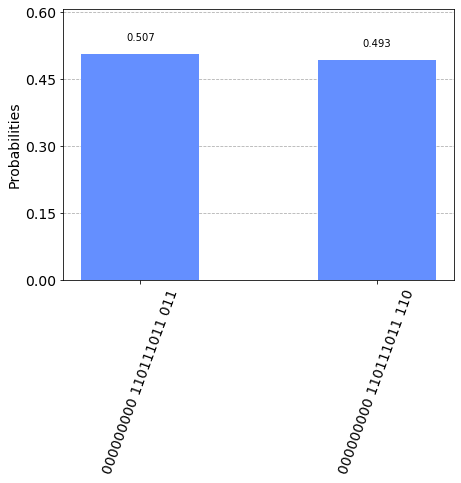

In [12]:
plot_histogram(res.get_counts())

Credentials are already in use. The existing account in the session will be replaced.


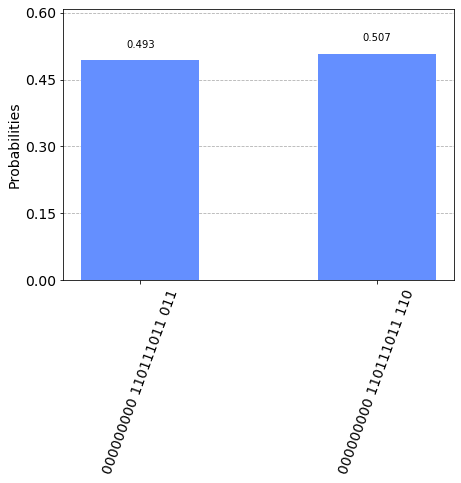

In [38]:
# Running on IBMQ Experience

# saving account credentials first
#IBMQ.save_account('MY_TOKEN_ID')

# loading IBMQ session
provider = IBMQ.load_account()
backend = provider.backends(simulator=True,operational=True)[0]
res = execute(qc, backend, shots=8192).result()
plot_histogram(res.get_counts())

In [ ]:
# TODO: create circuit for n=2 network and test it on melbourne qpu.